In [2]:
# Weather Image Classification Training

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from PIL import Image



In [3]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Data directory
data_dir = '../data'

# Data transformations for training, validation, and testing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Dataset loading
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                         data_transforms[x]) 
                 for x in ['train', 'valid', 'test']}

# DataLoaders
batch_size = 32
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=batch_size,
                                             shuffle=True, 
                                             num_workers=4)
              for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Training images: {dataset_sizes['train']}")
print(f"Validation images: {dataset_sizes['valid']}")
print(f"Test images: {dataset_sizes['test']}")

Classes: ['lightning', 'rainbow', 'sandstorm', 'snow']
Training images: 680
Validation images: 120
Test images: 120


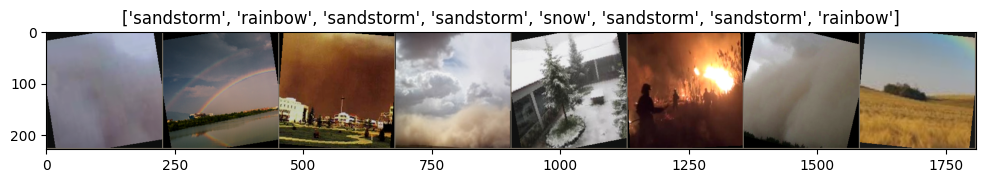

<Figure size 640x480 with 0 Axes>

In [5]:
# Function to display images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data and display
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:8])

plt.figure(figsize=(12, 6))
imshow(out, title=[class_names[x] for x in classes[:8]])
plt.savefig('../models/sample_images.png')

In [6]:

# Training function with plotting
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # For plotting
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Store statistics for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Plot training progress
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('../models/training_progress.png')
    plt.show()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs

# Function to visualize model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3 + 1, 3, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.savefig('../models/model_predictions.png')
                    return
        model.train(mode=was_training)
    plt.tight_layout()
    plt.savefig('../models/model_predictions.png')

# Test function
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    # Testing loop
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    # Create confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('../models/confusion_matrix.png')
    plt.show()
    
    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    return test_loss, test_acc

In [7]:

# Load pre-trained model (ResNet34)
model = models.resnet34(pretrained=True)

# First, freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Get the input features of the last layer
num_ftrs = model.fc.in_features

# Replace the last fully connected layer
model.fc = nn.Linear(num_ftrs, len(class_names))

# Move model to the device
model = model.to(device)


c:\Users\chomm\anaconda3\envs\bank-churn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chomm\anaconda3\envs\bank-churn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\chomm/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 11.7MB/s]


In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Set up optimizer with only the parameters of the new layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Training model in feature extraction mode...
Epoch 1/15
----------
train Loss: 1.0879 Acc: 0.5735
valid Loss: 0.8100 Acc: 0.7750

Epoch 2/15
----------
train Loss: 0.6839 Acc: 0.8353
valid Loss: 0.5564 Acc: 0.8917

Epoch 3/15
----------
train Loss: 0.5029 Acc: 0.8897
valid Loss: 0.4610 Acc: 0.8750

Epoch 4/15
----------
train Loss: 0.4334 Acc: 0.8735
valid Loss: 0.4405 Acc: 0.8750

Epoch 5/15
----------
train Loss: 0.4063 Acc: 0.8882
valid Loss: 0.3179 Acc: 0.9250

Epoch 6/15
----------
train Loss: 0.3572 Acc: 0.9103
valid Loss: 0.3042 Acc: 0.9083

Epoch 7/15
----------
train Loss: 0.3298 Acc: 0.9162
valid Loss: 0.2896 Acc: 0.9083

Epoch 8/15
----------
train Loss: 0.3078 Acc: 0.9044
valid Loss: 0.2784 Acc: 0.9167

Epoch 9/15
----------
train Loss: 0.3028 Acc: 0.9191
valid Loss: 0.2756 Acc: 0.9167

Epoch 10/15
----------
train Loss: 0.2973 Acc: 0.9118
valid Loss: 0.2719 Acc: 0.9083

Epoch 11/15
----------
train Loss: 0.2906 Acc: 0.9265
valid Loss: 0.2719 Acc: 0.9167

Epoch 12/15
------

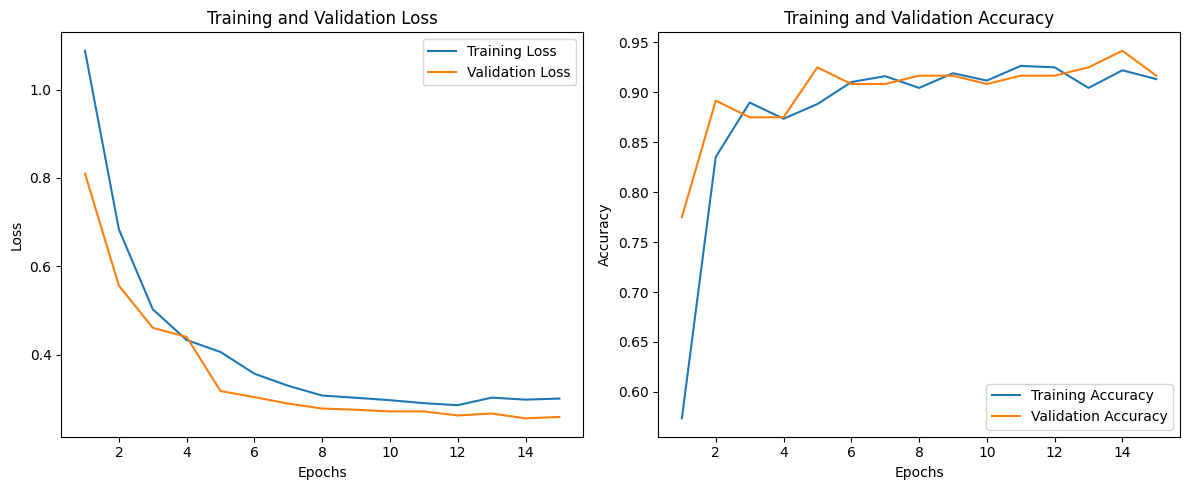

Training complete in 21m 53s
Best valid Acc: 0.9417


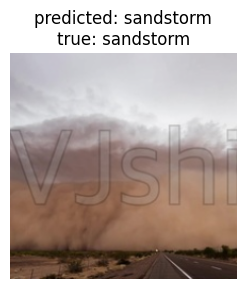

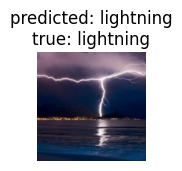

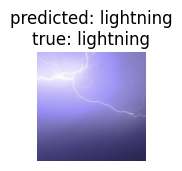

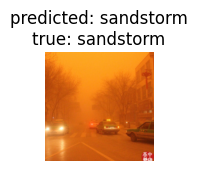

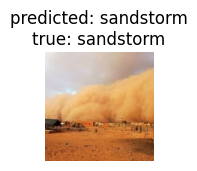

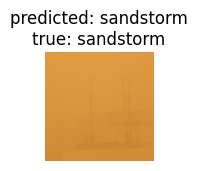

Fine-tuning the model...


<Figure size 640x480 with 0 Axes>

In [9]:
# Train the model (feature extraction)
print("Training model in feature extraction mode...")
model, train_losses, train_accs, val_losses, val_accs = train_model(
    model, criterion, optimizer, scheduler, num_epochs=15)

# Visualize some predictions
visualize_model(model)

# Now fine-tune the model by unfreezing some layers
print("Fine-tuning the model...")


Epoch 1/10
----------
train Loss: 0.2123 Acc: 0.9353
valid Loss: 0.0866 Acc: 0.9667

Epoch 2/10
----------
train Loss: 0.1824 Acc: 0.9397
valid Loss: 0.1062 Acc: 0.9667

Epoch 3/10
----------
train Loss: 0.1026 Acc: 0.9647
valid Loss: 0.0556 Acc: 0.9750

Epoch 4/10
----------
train Loss: 0.1307 Acc: 0.9500
valid Loss: 0.0634 Acc: 0.9667

Epoch 5/10
----------
train Loss: 0.1032 Acc: 0.9662
valid Loss: 0.0468 Acc: 0.9750

Epoch 6/10
----------
train Loss: 0.0940 Acc: 0.9721
valid Loss: 0.0706 Acc: 0.9917

Epoch 7/10
----------
train Loss: 0.1141 Acc: 0.9529
valid Loss: 0.0927 Acc: 0.9750

Epoch 8/10
----------
train Loss: 0.0814 Acc: 0.9735
valid Loss: 0.0706 Acc: 0.9750

Epoch 9/10
----------
train Loss: 0.0633 Acc: 0.9765
valid Loss: 0.0724 Acc: 0.9750

Epoch 10/10
----------
train Loss: 0.0713 Acc: 0.9794
valid Loss: 0.0732 Acc: 0.9750



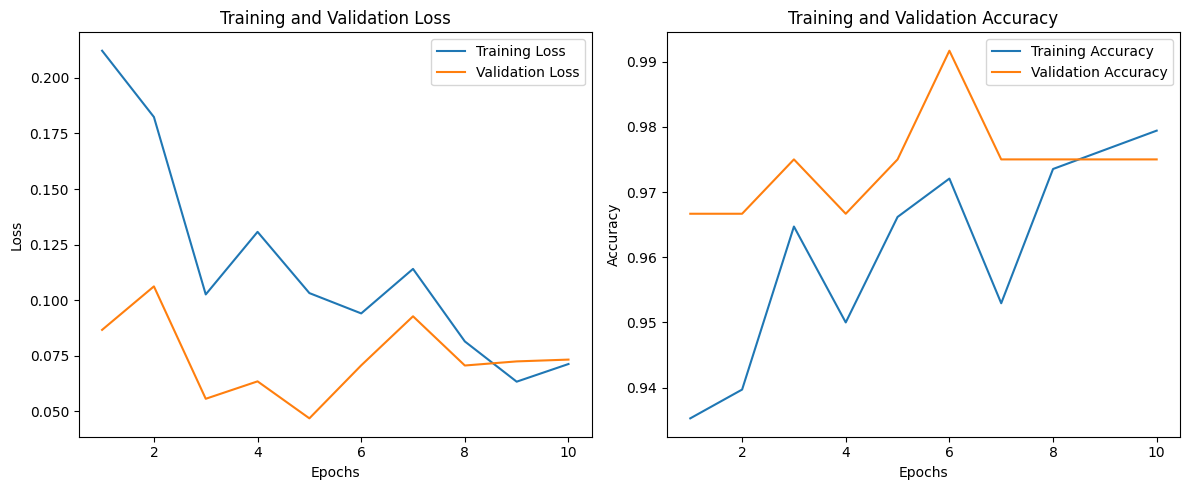

Training complete in 24m 9s
Best valid Acc: 0.9917


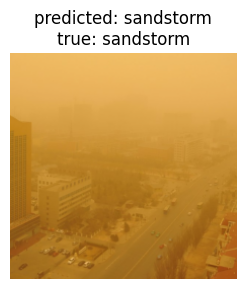

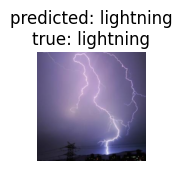

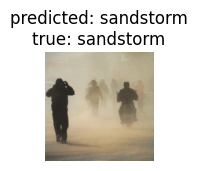

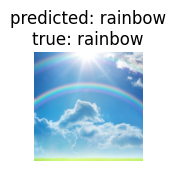

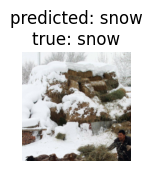

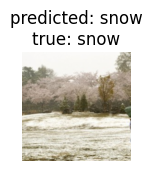

<Figure size 640x480 with 0 Axes>

In [10]:

# Unfreeze layers from layer 7 onwards (the last few layers)
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True

# Lower learning rate for fine-tuning
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Fine-tune the model
model, ft_train_losses, ft_train_accs, ft_val_losses, ft_val_accs = train_model(
    model, criterion, optimizer_ft, scheduler_ft, num_epochs=10)

# Visualize fine-tuned model predictions
visualize_model(model)


Test Loss: 0.0226 Acc: 0.9833


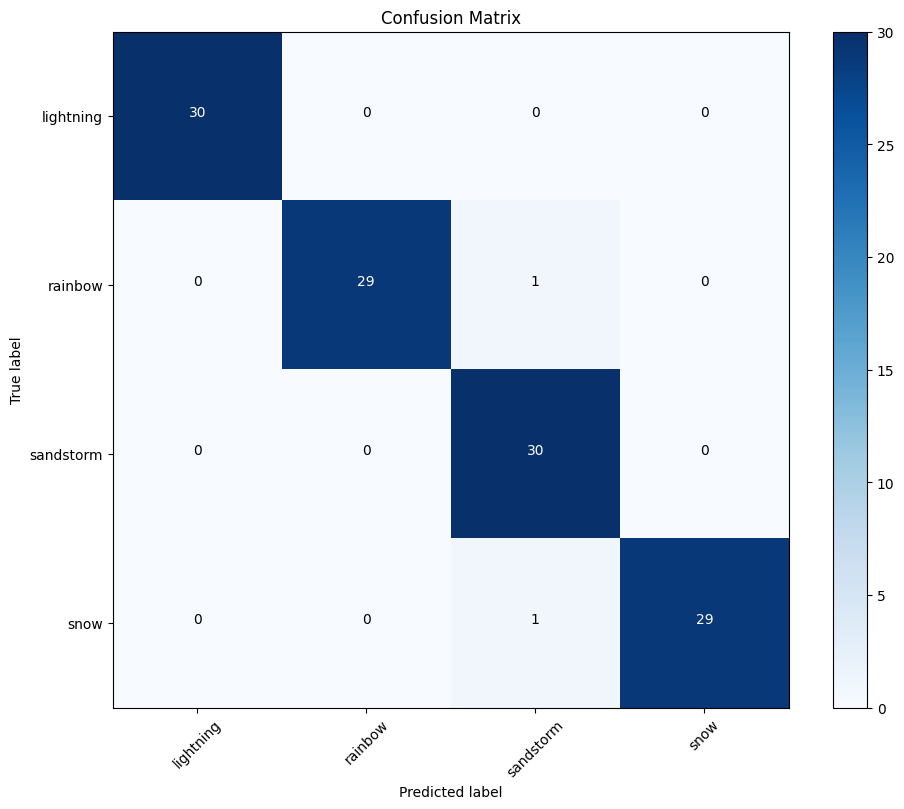

              precision    recall  f1-score   support

   lightning       1.00      1.00      1.00        30
     rainbow       1.00      0.97      0.98        30
   sandstorm       0.94      1.00      0.97        30
        snow       1.00      0.97      0.98        30

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [11]:
# Test the model
test_loss, test_acc = test_model(model, criterion)


In [12]:
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer_ft.state_dict(),
    'scheduler_state_dict': scheduler_ft.state_dict(),
    'class_names': class_names,
    'test_acc': test_acc,
}, '../models/weather_classifier.pth')

print(f"Model saved with test accuracy: {test_acc:.4f}")

# Save training history
history = {
    'train_losses': train_losses + ft_train_losses,
    'train_accs': train_accs + ft_train_accs,
    'val_losses': val_losses + ft_val_losses,
    'val_accs': val_accs + ft_val_accs,
}

import pickle
with open('../models/training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("Training history saved.")

Model saved with test accuracy: 0.9833
Training history saved.
